In [1]:
# Cell 1: 기본 모듈 import

import os
from pathlib import Path
import json

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

from PIL import Image
import torchvision.transforms as T
import torchvision.models as models

from pycocotools.coco import COCO

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Cell 2: 경로 및 디바이스 설정

PROJECT_ROOT = Path("..").resolve()

COCO_DIR = PROJECT_ROOT / "data" / "CarDD_COCO"
ANN_TRAIN = COCO_DIR / "annotations" / "instances_train2017.json"
ANN_VAL   = COCO_DIR / "annotations" / "instances_val2017.json"
#ANN_TEST  = COCO_DIR / "annotations" / "instances_test2017.json"

TRAIN_IMG_DIR = COCO_DIR / "train2017"
VAL_IMG_DIR   = COCO_DIR / "val2017"
TEST_IMG_DIR  = COCO_DIR / "test2017"

# location 정보를 위한 엑셀 (shooting angle)
INFO_XLSX = COCO_DIR / "annotations" / "image_info.xlsx"

MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("COCO_DIR:", COCO_DIR)
print("TRAIN_IMG_DIR:", TRAIN_IMG_DIR)
print("VAL_IMG_DIR:", VAL_IMG_DIR)
#print("TEST_IMG_DIR:", TEST_IMG_DIR)
print("MODELS_DIR:", MODELS_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


PROJECT_ROOT: C:\Users\user\Documents\python_ws\visionqc-local-ai
COCO_DIR: C:\Users\user\Documents\python_ws\visionqc-local-ai\data\CarDD_COCO
TRAIN_IMG_DIR: C:\Users\user\Documents\python_ws\visionqc-local-ai\data\CarDD_COCO\train2017
VAL_IMG_DIR: C:\Users\user\Documents\python_ws\visionqc-local-ai\data\CarDD_COCO\val2017
MODELS_DIR: C:\Users\user\Documents\python_ws\visionqc-local-ai\models


device(type='cuda')

In [3]:
# Cell 3: 클래스(label) 정의
import pandas as pd

# 학습에 사용할 defect 클래스 (no_defect는 포함하지 않음)
DEFECT_LABELS = [
    "dent",
    "scratch",
    "crack",
    "glass_shatter",
    "lamp_broken",
    "tire_flat",
]

# severity:
SEVERITY_LABELS = ["minor", "moderate", "severe"]

# location: image_info.xlsx의 shooting angle에서 매핑
LOCATION_LABELS = ["front", "rear", "side"]

DEFECT2IDX   = {lbl: i for i, lbl in enumerate(DEFECT_LABELS)}
IDX2DEFECT   = {i: lbl for lbl, i in DEFECT2IDX.items()}

SEVERITY2IDX = {lbl: i for i, lbl in enumerate(SEVERITY_LABELS)}
IDX2SEVERITY = {i: lbl for lbl, i in SEVERITY2IDX.items()}

LOCATION2IDX = {lbl: i for i, lbl in enumerate(LOCATION_LABELS)}
IDX2LOCATION = {i: lbl for lbl, i in LOCATION2IDX.items()}

DEFECT2IDX, SEVERITY2IDX, LOCATION2IDX


({'dent': 0,
  'scratch': 1,
  'crack': 2,
  'glass_shatter': 3,
  'lamp_broken': 4,
  'tire_flat': 5},
 {'minor': 0, 'moderate': 1, 'severe': 2},
 {'front': 0, 'rear': 1, 'side': 2})

In [4]:
# Cell 4: image_info.xlsx 로드 및 file_name -> location 매핑

df_info = pd.read_excel(INFO_XLSX)

print("image_info columns:", df_info.columns)
# 예상: ['file_name', 'shooting angle', 'complete or partial', 'color', ...]

df_info["file_name"] = df_info["file_name"].astype(str)
df_info["shooting angle"] = df_info["shooting angle"].astype(str).str.lower().str.strip()

def map_location_from_angle(angle: str) -> str:
    angle = angle.lower()
    if "front" in angle:
        return "front"
    if "rear" in angle:
        return "rear"
    if "side" in angle:
        return "side"
    # 애매하면 일단 front로
    return "front"

df_info["location"] = df_info["shooting angle"].apply(map_location_from_angle)

# file_name -> location 매핑 딕셔너리
FILENAME2LOCATION = dict(zip(df_info["file_name"], df_info["location"]))

len(FILENAME2LOCATION)


image_info columns: Index(['id', 'file_name', 'width', 'height', 'file_size (KB)', '#instances',
       '#categories', 'shooting angle', 'complete or partial ', 'color'],
      dtype='object')


4000

In [5]:
# Cell 5: COCO annotation + #instances + complete/partial 기반 멀티태스크 라벨 생성

from pycocotools.coco import COCO

# 1) df_info를 file_name 기준 lookup 딕셔너리로 변환
#    예: df_info_lookup["000001.jpg"] -> {
#           'id': ...,
#           'file_name': ...,
#           'width': ...,
#           '#instances': ...,
#           'complete or partial ': ...,
#           'location': ...
#        }
df_info_lookup = df_info.set_index("file_name").to_dict("index")

def normalize_defect_name(raw_name: str) -> str:
    """
    COCO category name을 우리 DEFECT_LABELS에 맞게 정규화.
    예: "glass shatter" -> "glass_shatter"
    """
    x = raw_name.lower().strip().replace(" ", "_")
    return x

def map_defect_name(raw_name: str) -> str:
    """
    정규화된 name을 DEFECT_LABELS 안에 맞게 매핑.
    CarDD는 전부 손상 이미지라서 no_defect는 여기서 만들지 않음.
    """
    x = normalize_defect_name(raw_name)
    if x in DEFECT2IDX:
        return x
    # 혹시 예외 라벨이면 일단 dent로 보내기 (원하면 나중에 조정)
    return "dent"

def map_severity_using_metadata(instances: int, complete_partial: str) -> str:
    """
    #instances + complete or partial 기반 severity 결정.

    - complete  이면 무조건 severe
    - instances >= 4 -> severe
    - instances 2~3 -> moderate
    - instances 1   -> minor
    - 그 외         -> none
    """
    cp = str(complete_partial).strip().lower()

    if cp == "complete":
        return "severe"

    if instances >= 4:
        return "severe"
    elif instances >= 2:
        return "moderate"
    elif instances == 1:
        return "minor"
    else:
        return "minor"

def load_coco_multitask_items(ann_path: Path, img_dir: Path):
    """
    COCO annotations + image_info.xlsx 기반으로
    [
      {
        "file_name": ...,
        "filepath": ...,
        "defect": int,
        "severity": int,
        "location": int,
      },
      ...
    ]
    리스트 생성
    """
    coco = COCO(str(ann_path))
    items = []

    img_ids = coco.getImgIds()
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info["file_name"]

        # annotation들 가져오기
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)

        if len(anns) == 0:
            # 손상 annotation이 없는 경우는 스킵 (원하면 no_defect로 처리 가능)
            continue

        # 첫 번째 annotation 기준으로 defect 사용
        first_ann = anns[0]
        cat_id = first_ann["category_id"]
        cat_info = coco.loadCats([cat_id])[0]
        raw_name = cat_info["name"]

        defect_name = map_defect_name(raw_name)

        # image_info.xlsx에서 메타데이터 조회
        info_row = df_info_lookup.get(file_name, None)

        if info_row is not None:
            instances = int(info_row["#instances"])
            complete_partial = info_row["complete or partial "]
            location_name = info_row["location"]
        else:
            # 혹시 image_info에 없는 파일이면 기본값 설정
            instances = 1
            complete_partial = "partial"
            location_name = "front"

        severity_name = map_severity_using_metadata(instances, complete_partial)

        item = {
            "file_name": file_name,
            "filepath": str(img_dir / file_name),
            "defect":   DEFECT2IDX[defect_name],
            "severity": SEVERITY2IDX[severity_name],
            "location": LOCATION2IDX[location_name],
        }
        items.append(item)

    return items

In [6]:
# Cell 6
train_items = load_coco_multitask_items(ANN_TRAIN, TRAIN_IMG_DIR)
val_items   = load_coco_multitask_items(ANN_VAL,   VAL_IMG_DIR)
#test_items  = load_coco_multitask_items(ANN_TEST,  TEST_IMG_DIR)

len(train_items), len(val_items), #len(test_items)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


(2816, 810)

In [7]:
# Cell 7 Dataset & Transform 정의
IMG_SIZE = 224

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class CarDamageMultiTaskDataset(Dataset):
    def __init__(self, items, transform=None):
        self.items = items
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img = Image.open(it["filepath"]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        y_def = it["defect"]
        y_sev = it["severity"]
        y_loc = it["location"]

        return img, y_def, y_sev, y_loc


train_dataset = CarDamageMultiTaskDataset(train_items, transform=train_transform)
val_dataset   = CarDamageMultiTaskDataset(val_items,   transform=val_transform)

len(train_dataset), len(val_dataset)

(2816, 810)

In [8]:
# Cell 8: WeightedRandomSampler 생성 (defect 불균형 보정) + DataLoader

num_classes = len(DEFECT_LABELS)
class_counts = np.zeros(num_classes, dtype=np.int64)

for it in train_items:
    class_counts[it["defect"]] += 1

print("class_counts (by defect index):", class_counts)
print("DEFECT_LABELS:", DEFECT_LABELS)

# 클래스가 적을수록 weight 크게
class_weights = 1.0 / np.clip(class_counts, 1, None)
sample_weights = np.array([class_weights[it["defect"]] for it in train_items], dtype=np.float32)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)

len(train_loader), len(val_loader)

class_counts (by defect index): [1242  859   83  391   69  172]
DEFECT_LABELS: ['dent', 'scratch', 'crack', 'glass_shatter', 'lamp_broken', 'tire_flat']


(88, 13)

In [9]:
# Cell 9: 멀티태스크 ResNet34 모델 정의

class VisionQCMultiTaskResNet34(nn.Module):
    def __init__(self,
                 num_defect: int,
                 num_severity: int,
                 num_location: int,
                 pretrained: bool = True):
        super().__init__()
        backbone = models.resnet34(
            weights=models.ResNet34_Weights.IMAGENET1K_V1 if pretrained else None
        )
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()
        self.backbone = backbone

        self.fc_defect   = nn.Linear(in_features, num_defect)
        self.fc_severity = nn.Linear(in_features, num_severity)
        self.fc_location = nn.Linear(in_features, num_location)

    def forward(self, x):
        feat = self.backbone(x)
        logits_defect   = self.fc_defect(feat)
        logits_severity = self.fc_severity(feat)
        logits_location = self.fc_location(feat)

        return {
            "defect_type": logits_defect,
            "severity": logits_severity,
            "location": logits_location,
        }


model = VisionQCMultiTaskResNet34(
    num_defect=len(DEFECT_LABELS),
    num_severity=len(SEVERITY_LABELS),
    num_location=len(LOCATION_LABELS),
    pretrained=True,
).to(device)

model

VisionQCMultiTaskResNet34(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [10]:
# Cell 10: Phase별 trainable layer 설정 + Loss, Train/Eval 함수

criterion = nn.CrossEntropyLoss()


def set_trainable_layers_phase1(model):
    """
    Phase 1: backbone은 모두 freeze,
             fc_defect / fc_severity / fc_location 만 학습
    """
    # 1) 전체 freeze
    for param in model.parameters():
        param.requires_grad = False

    # 2) head 3개만 unfreeze
    for param in model.fc_defect.parameters():
        param.requires_grad = True
    for param in model.fc_severity.parameters():
        param.requires_grad = True
    for param in model.fc_location.parameters():
        param.requires_grad = True

    # 3) requires_grad=True 인 파라미터만 optimizer에 전달
    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3,        # head만 학습이니까 약간 크게
        momentum=0.9,
        weight_decay=1e-4,
    )

    scheduler = StepLR(
        optimizer,
        step_size=5,
        gamma=0.1,
    )
    return optimizer, scheduler


def set_trainable_layers_phase2(model):
    """
    Phase 2: backbone.layer4 + head(3개) 학습
    (상위 블록 파인튜닝)
    """
    # 1) 전체 freeze
    for param in model.parameters():
        param.requires_grad = False

    # 2) backbone.layer4 + head 3개 unfreeze
    for param in model.backbone.layer4.parameters():
        param.requires_grad = True
    for param in model.fc_defect.parameters():
        param.requires_grad = True
    for param in model.fc_severity.parameters():
        param.requires_grad = True
    for param in model.fc_location.parameters():
        param.requires_grad = True

    optimizer = torch.optim.SGD(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3,          # Phase2라서 적당한 LR
        momentum=0.9,
        weight_decay=1e-4,
    )

    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=15,         # 대략 phase2 epoch 수에 맞춰주면 됨
        eta_min=1e-5,
    )
    return optimizer, scheduler


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, y_def, y_sev, y_loc in pbar:
        imgs = imgs.to(device)
        y_def = y_def.to(device)
        y_sev = y_sev.to(device)
        y_loc = y_loc.to(device)

        optimizer.zero_grad()
        out = model(imgs)

        loss_def = criterion(out["defect_type"], y_def)
        loss_sev = criterion(out["severity"],    y_sev)
        loss_loc = criterion(out["location"],    y_loc)

        loss = 1.0 * loss_def + 0.7 * loss_sev + 0.7 * loss_loc

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss


def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct_def = correct_sev = correct_loc = 0
    total = 0

    pbar = tqdm(loader, desc="Val", leave=False)
    with torch.no_grad():
        for imgs, y_def, y_sev, y_loc in pbar:
            imgs = imgs.to(device)
            y_def = y_def.to(device)
            y_sev = y_sev.to(device)
            y_loc = y_loc.to(device)

            out = model(imgs)

            loss_def = criterion(out["defect_type"], y_def)
            loss_sev = criterion(out["severity"],    y_sev)
            loss_loc = criterion(out["location"],    y_loc)
            loss = 1.0 * loss_def + 0.7 * loss_sev + 0.7 * loss_loc

            total_loss += loss.item() * imgs.size(0)

            pred_def = out["defect_type"].argmax(dim=1)
            pred_sev = out["severity"].argmax(dim=1)
            pred_loc = out["location"].argmax(dim=1)

            correct_def += (pred_def == y_def).sum().item()
            correct_sev += (pred_sev == y_sev).sum().item()
            correct_loc += (pred_loc == y_loc).sum().item()
            total += imgs.size(0)

    avg_loss = total_loss / len(loader.dataset)
    acc_def = correct_def / total
    acc_sev = correct_sev / total
    acc_loc = correct_loc / total

    return avg_loss, acc_def, acc_sev, acc_loc


In [11]:
# Cell 11: 2-Phase 학습 루프 + history 기록 + best pth 저장

EPOCHS_PHASE1 = 5
EPOCHS_PHASE2 = 15
total_epochs = EPOCHS_PHASE1 + EPOCHS_PHASE2

best_val_loss = float("inf")
best_model_path = MODELS_DIR / "visionqc_multitask_resnet34_best.pth"
best_epoch = None
best_phase = None

# 🔹 학습 로그 저장용 history 딕셔너리
history = {
    "epoch": [],
    "phase": [],
    "train_loss": [],
    "val_loss": [],
    "acc_def": [],
    "acc_sev": [],
    "acc_loc": [],
    "lr": [],
}

# -------- Phase 1: Head만 학습 (early stop X) --------
print("\n========== Phase 1: FC Heads only ==========")
optimizer, scheduler = set_trainable_layers_phase1(model)

for epoch in range(1, EPOCHS_PHASE1 + 1):
    global_epoch = epoch  # 1~EPOCHS_PHASE1
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"\n[Phase 1 - Epoch {global_epoch}/{total_epochs}]  lr={current_lr:.6f}")

    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, acc_def, acc_sev, acc_loc = evaluate(model, val_loader, device)

    print(f"  train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | "
          f"acc_def={acc_def:.3f}, acc_sev={acc_sev:.3f}, acc_loc={acc_loc:.3f}")

    scheduler.step()

    # 🔹 history 기록
    history["epoch"].append(global_epoch)
    history["phase"].append("phase1")
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["acc_def"].append(acc_def)
    history["acc_sev"].append(acc_sev)
    history["acc_loc"].append(acc_loc)
    history["lr"].append(current_lr)

    # ✔ best model만 업데이트 (early stop은 안 함)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = global_epoch
        best_phase = "phase1"
        torch.save(model.state_dict(), best_model_path)
        print(f"  Best model updated: {best_model_path}")


# -------- Phase 2: backbone.layer4 + Heads 학습 (early stopping O) --------
print("\n========== Phase 2: layer4 + FC Heads ==========")
optimizer, scheduler = set_trainable_layers_phase2(model)

# 🔹 Early Stopping 설정 (Phase 2에서만 사용)
patience = 3       # 전체 20 epoch 기준이면 이 정도가 적당
min_delta = 1e-4
no_improve_cnt = 0

for epoch in range(1, EPOCHS_PHASE2 + 1):
    global_epoch = EPOCHS_PHASE1 + epoch  # EPOCHS_PHASE1+1 ~ total_epochs
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"\n[Phase 2 - Epoch {global_epoch}/{total_epochs}]  lr={current_lr:.6f}")

    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, acc_def, acc_sev, acc_loc = evaluate(model, val_loader, device)

    print(f"  train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | "
          f"acc_def={acc_def:.3f}, acc_sev={acc_sev:.3f}, acc_loc={acc_loc:.3f}")

    scheduler.step()

    # 🔹 history 기록
    history["epoch"].append(global_epoch)
    history["phase"].append("phase2")
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["acc_def"].append(acc_def)
    history["acc_sev"].append(acc_sev)
    history["acc_loc"].append(acc_loc)
    history["lr"].append(current_lr)

    # 🔹 Phase 2에서만 early stopping 적용
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = global_epoch
        best_phase = "phase2"
        no_improve_cnt = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"  Best model updated: {best_model_path}")
    else:
        no_improve_cnt += 1
        print(f"  (no improvement count: {no_improve_cnt}/{patience})")

    if no_improve_cnt >= patience:
        print("  Early stopping triggered in Phase 2.")
        break

print("\n===== Training Finished =====")
print(f"Best val_loss = {best_val_loss:.4f} at epoch {best_epoch} ({best_phase})")



========== Phase 1: FC Heads only ==========

[Phase 1 - Epoch 1/20]  lr=0.001000


  train_loss=2.5311 | val_loss=2.8470 | acc_def=0.385, acc_sev=0.469, acc_loc=0.681
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 1 - Epoch 2/20]  lr=0.001000


  train_loss=1.9008 | val_loss=2.5944 | acc_def=0.417, acc_sev=0.486, acc_loc=0.688
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 1 - Epoch 3/20]  lr=0.001000


  train_loss=1.7207 | val_loss=2.3715 | acc_def=0.526, acc_sev=0.491, acc_loc=0.741
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 1 - Epoch 4/20]  lr=0.001000


  train_loss=1.6549 | val_loss=2.3468 | acc_def=0.512, acc_sev=0.517, acc_loc=0.744
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 1 - Epoch 5/20]  lr=0.001000


  train_loss=1.5794 | val_loss=2.1786 | acc_def=0.598, acc_sev=0.506, acc_loc=0.756
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

========== Phase 2: layer4 + FC Heads ==========

[Phase 2 - Epoch 6/20]  lr=0.001000


  train_loss=1.3901 | val_loss=1.9186 | acc_def=0.665, acc_sev=0.543, acc_loc=0.788
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 2 - Epoch 7/20]  lr=0.000989


  train_loss=1.0627 | val_loss=1.8209 | acc_def=0.705, acc_sev=0.542, acc_loc=0.816
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 2 - Epoch 8/20]  lr=0.000957


  train_loss=0.9713 | val_loss=1.7401 | acc_def=0.740, acc_sev=0.574, acc_loc=0.781
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 2 - Epoch 9/20]  lr=0.000905


  train_loss=0.8738 | val_loss=1.6996 | acc_def=0.736, acc_sev=0.591, acc_loc=0.819
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 2 - Epoch 10/20]  lr=0.000836


  train_loss=0.7946 | val_loss=1.7612 | acc_def=0.722, acc_sev=0.586, acc_loc=0.823
  (no improvement count: 1/3)

[Phase 2 - Epoch 11/20]  lr=0.000752


  train_loss=0.6885 | val_loss=1.6795 | acc_def=0.746, acc_sev=0.595, acc_loc=0.816
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 2 - Epoch 12/20]  lr=0.000658


  train_loss=0.6612 | val_loss=1.6704 | acc_def=0.740, acc_sev=0.575, acc_loc=0.840
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 2 - Epoch 13/20]  lr=0.000557


  train_loss=0.6407 | val_loss=1.6822 | acc_def=0.743, acc_sev=0.563, acc_loc=0.826
  (no improvement count: 1/3)

[Phase 2 - Epoch 14/20]  lr=0.000453


  train_loss=0.6153 | val_loss=1.6628 | acc_def=0.738, acc_sev=0.598, acc_loc=0.833
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 2 - Epoch 15/20]  lr=0.000352


  train_loss=0.5969 | val_loss=1.6488 | acc_def=0.752, acc_sev=0.577, acc_loc=0.840
  Best model updated: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Phase 2 - Epoch 16/20]  lr=0.000258


  train_loss=0.5588 | val_loss=1.6519 | acc_def=0.744, acc_sev=0.588, acc_loc=0.836
  (no improvement count: 1/3)

[Phase 2 - Epoch 17/20]  lr=0.000174


  train_loss=0.5347 | val_loss=1.6602 | acc_def=0.744, acc_sev=0.593, acc_loc=0.821
  (no improvement count: 2/3)

[Phase 2 - Epoch 18/20]  lr=0.000105


  train_loss=0.5707 | val_loss=1.6545 | acc_def=0.744, acc_sev=0.591, acc_loc=0.836
  (no improvement count: 3/3)
  Early stopping triggered in Phase 2.

===== Training Finished =====
Best val_loss = 1.6488 at epoch 15 (phase2)


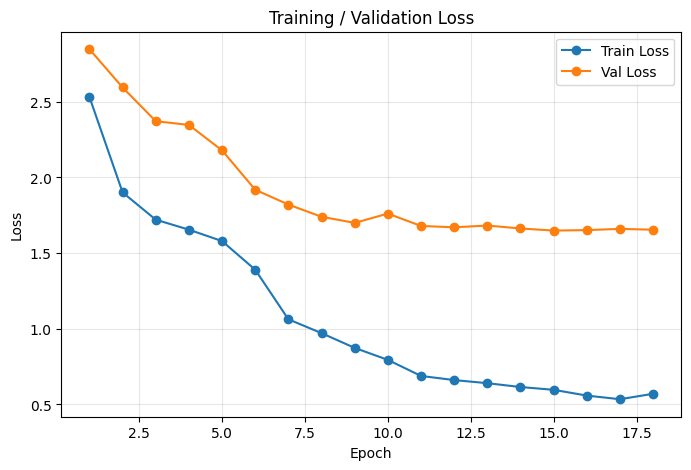

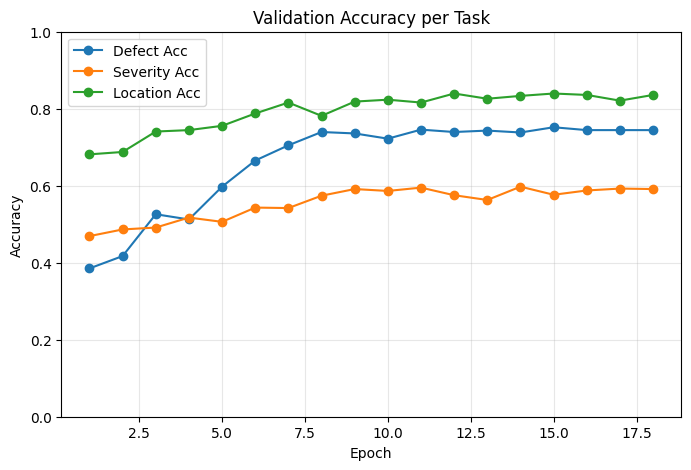

Best val_loss = 1.6488 at epoch 15 (phase2)
Best model path: C:\Users\user\Documents\python_ws\visionqc-local-ai\models\visionqc_multitask_resnet34_best.pth

[Best Model] Evaluation on Validation Set


  val_loss=1.6488 | acc_def=0.752, acc_sev=0.577, acc_loc=0.840


In [12]:
# Cell 12: 학습 곡선 시각화 + best 모델 (Validation 기준 성능만)

# 1) 학습/검증 loss 곡선
epochs = history["epoch"]
train_losses = history["train_loss"]
val_losses = history["val_loss"]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker="o", label="Train Loss")
plt.plot(epochs, val_losses, marker="o", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 2) 태스크별 validation accuracy 곡선
acc_def_hist = history["acc_def"]
acc_sev_hist = history["acc_sev"]
acc_loc_hist = history["acc_loc"]

plt.figure(figsize=(8, 5))
plt.plot(epochs, acc_def_hist, marker="o", label="Defect Acc")
plt.plot(epochs, acc_sev_hist, marker="o", label="Severity Acc")
plt.plot(epochs, acc_loc_hist, marker="o", label="Location Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Task")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Best val_loss = {best_val_loss:.4f} at epoch {best_epoch} ({best_phase})")
print("Best model path:", best_model_path)

# 3) Best 모델 로드해서 Validation Set 성능 다시 측정
best_model = VisionQCMultiTaskResNet34(
    num_defect=len(DEFECT_LABELS),
    num_severity=len(SEVERITY_LABELS),
    num_location=len(LOCATION_LABELS),
    pretrained=False,  # 이미 weight 로드할 것이므로 False
).to(device)

state_dict = torch.load(best_model_path, map_location=device)
best_model.load_state_dict(state_dict)

print("\n[Best Model] Evaluation on Validation Set")
val_loss_best, acc_def_best, acc_sev_best, acc_loc_best = evaluate(best_model, val_loader, device)
print(f"  val_loss={val_loss_best:.4f} | "
      f"acc_def={acc_def_best:.3f}, acc_sev={acc_sev_best:.3f}, acc_loc={acc_loc_best:.3f}")


DEFECT LABELS: ['dent', 'scratch', 'crack', 'glass_shatter', 'lamp_broken', 'tire_flat']
SEVERITY LABELS: ['minor', 'moderate', 'severe']
LOCATION LABELS: ['front', 'rear', 'side']


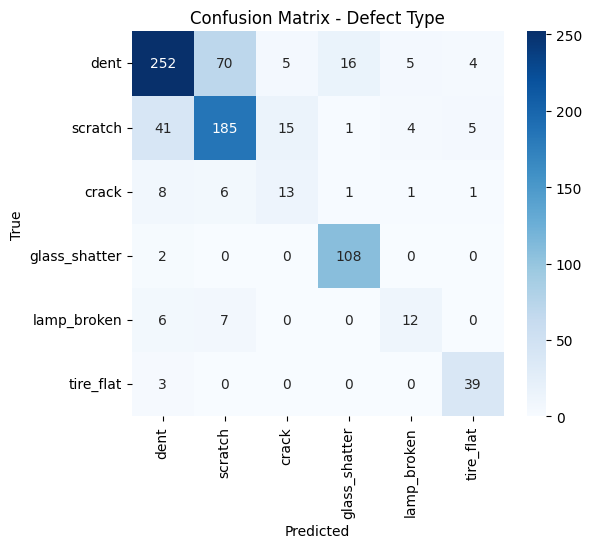

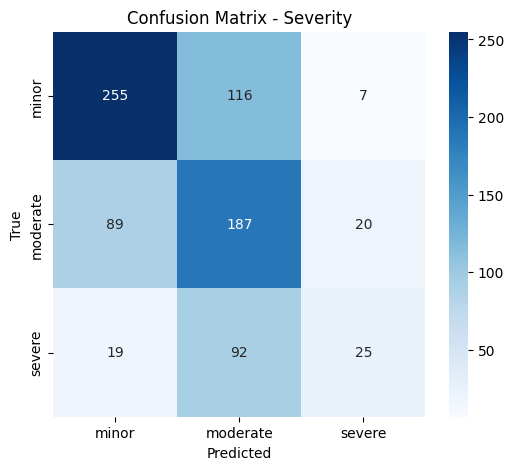

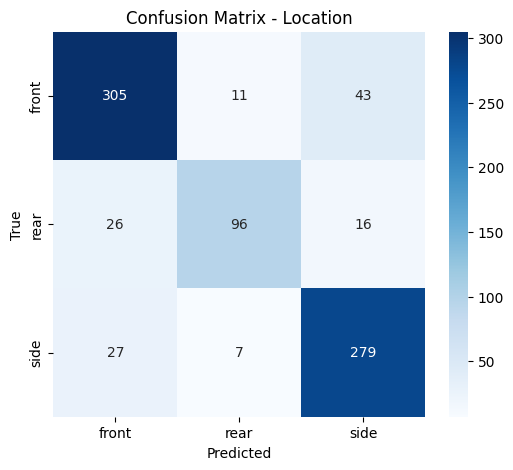

In [13]:
# Cell 13: Confusion Matrix (Validation Set)

from sklearn.metrics import confusion_matrix
import seaborn as sns

# ----------------------------
# 1) Validation 전체 예측 수집
# ----------------------------

all_true_def = []
all_pred_def = []

all_true_sev = []
all_pred_sev = []

all_true_loc = []
all_pred_loc = []

best_model.eval()
with torch.no_grad():
    for imgs, y_def, y_sev, y_loc in val_loader:
        imgs = imgs.to(device)

        out = best_model(imgs)

        pred_def = out["defect_type"].argmax(dim=1).cpu().numpy()
        pred_sev = out["severity"].argmax(dim=1).cpu().numpy()
        pred_loc = out["location"].argmax(dim=1).cpu().numpy()

        all_pred_def.extend(pred_def)
        all_pred_sev.extend(pred_sev)
        all_pred_loc.extend(pred_loc)

        all_true_def.extend(y_def.numpy())
        all_true_sev.extend(y_sev.numpy())
        all_true_loc.extend(y_loc.numpy())


# ----------------------------
# 2) Confusion Matrix 계산
# ----------------------------
cm_def = confusion_matrix(all_true_def, all_pred_def)
cm_sev = confusion_matrix(all_true_sev, all_pred_sev)
cm_loc = confusion_matrix(all_true_loc, all_pred_loc)


# ----------------------------
# 3) 시각화 함수
# ----------------------------
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


# ----------------------------
# 4) 출력
# ----------------------------

print("DEFECT LABELS:", DEFECT_LABELS)
print("SEVERITY LABELS:", SEVERITY_LABELS)
print("LOCATION LABELS:", LOCATION_LABELS)

plot_confusion_matrix(cm_def, DEFECT_LABELS, "Confusion Matrix - Defect Type")
plot_confusion_matrix(cm_sev, SEVERITY_LABELS, "Confusion Matrix - Severity")
plot_confusion_matrix(cm_loc, LOCATION_LABELS, "Confusion Matrix - Location")
